# Regression analysis

## Libraries and settings

In [71]:
# Libraries
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show current working directory
print(os.getcwd())

/workspaces/data_analytics/WTYK/LC_08


## Import car data

In [72]:
# Columns
columns = ['Offer_Id', 
           'Price_num', 
           'Mileage_num',
           'HP_num', 
           'Make',
           'Fuel_Type', 
           'Transmission', 
           'Init_Regist_MY']

# Read the data
df_orig = pd.read_csv('autoscout24_data_prepared.csv', 
                      sep=",", 
                      encoding='utf-8',
                      usecols=columns)

# Rename variable 'web-scraper-order' to 'apmt_id'
df_orig = df_orig.rename(columns={'Mileage_num': 'Mileage',
                                  'HP_num': 'HP',
                                  'Price_num': 'Price'})

# Extract year from 'Init_Regist_MY' weil es ein String ist
df_orig['Init_Regist_MY'] = df_orig['Init_Regist_MY'].astype(str)
df_orig['Year'] = df_orig['Init_Regist_MY'].str.split('.').str[1].astype(int)
df_orig.drop('Init_Regist_MY', axis=1, inplace=True)

# Remove missing values
df = df_orig.dropna()
df.head(5)

# Remove duplicates
df = df.drop_duplicates()
df.head(5)

# Remove some extreme prices; keep only fuel type 'Diesel' and 'Benzin' um die Datenmenge zu reduzieren
df = df.loc[(df['Price'] >= 10000) & (df['Price'] <= 100000) & (df['Fuel_Type'].isin(['Diesel','Benzin']))]

# Show dimensions (rows and columns)
print(df.shape)

# Show the data
df.head()


(2845, 8)


,Offer_Id,Fuel_Type,Transmission,Make,Mileage,HP,Price,Year
0,7324420,Diesel,Automatisiertes Schaltgetriebe,AUDI,75000,245,22500,2014
1,7512768,Benzin,Automat sequentiell,MERCEDES-BENZ,46655,184,23749,2013
2,7512034,Benzin,Automat sequentiell,MERCEDES-BENZ,138955,306,18500,2011
3,7512728,Benzin,Automatisiertes Schaltgetriebe,MERCEDES-BENZ,43000,360,36000,2015
4,7490242,Benzin,Automatisiertes Schaltgetriebe,AUDI,43300,252,48500,2018


target ist preis, wir können jahr und mileage nutzen, es werden für jedes eine neue kategorie in der Tabelle, Beispiel Benzin und Diesel -> welches Auto =  0 und 1

## One-hot encoding of categorical variables

In [73]:
# Perform one-hot encoding on the 'Fuel_Type' column using the get_dummies() function
one_hot_encoded = pd.get_dummies(df['Fuel_Type']).astype(int)

# Concatenate the new one-hot encoded columns with the original DataFrame
df = pd.concat([df, one_hot_encoded], axis=1)
df

,Offer_Id,Fuel_Type,Transmission,Make,Mileage,HP,Price,Year,Benzin,Diesel
0,7324420,Diesel,Automatisiertes Schaltgetriebe,AUDI,75000,245,22500,2014,0,1
1,7512768,Benzin,Automat sequentiell,MERCEDES-BENZ,46655,184,23749,2013,1,0
2,7512034,Benzin,Automat sequentiell,MERCEDES-BENZ,138955,306,18500,2011,1,0
3,7512728,Benzin,Automatisiertes Schaltgetriebe,MERCEDES-BENZ,43000,360,36000,2015,1,0
4,7490242,Benzin,Automatisiertes Schaltgetriebe,AUDI,43300,252,48500,2018,1,0
...,...,...,...,...,...,...,...,...,...,...
3964,6058456,Benzin,Automat,BENTLEY,26200,405,38500,2001,1,0
3966,7137137,Benzin,Automatisiertes Schaltgetriebe,FERRARI,78000,400,58400,2002,1,0
3967,6758841,Benzin,Automatik-Getriebe,MERCEDES-BENZ,315000,232,15900,1987,1,0
3968,7461330,Benzin,Automat sequentiell,MERCEDES-BENZ,85000,525,42000,2007,1,0


## Create train and test samples (train = 80%, test = 20% of the data)

In [74]:
# Create train and test samples
x_train, x_test, y_train, y_test = train_test_split (df[['Mileage', 'HP', 'Diesel', 'Benzin']], 
                                                     df['Price'],
                                                     test_size=0.2, random_state=42)

# Show X_train
print(x_train)
print(x_train.head(), '\n')

# Show y_train
print(y_train)
print(y_train.head())

      Mileage   HP  Diesel  Benzin
968     64000  136       1       0
3914   205000  400       0       1
3068    52700  211       0       1
1047   270000  258       1       0
2700    39000  105       0       1
...       ...  ...     ...     ...
2251    17000  230       0       1
1464    52000  258       1       0
1518    14000  125       0       1
1764    75500  280       0       1
1147    45800  400       0       1

[2276 rows x 4 columns]
      Mileage   HP  Diesel  Benzin
968     64000  136       1       0
3914   205000  400       0       1
3068    52700  211       0       1
1047   270000  258       1       0
2700    39000  105       0       1 

968     22900
3914    19500
3068    15900
1047    28000
2700    10900
        ...  
2251    29900
1464    54900
1518    15900
1764    21900
1147    53800
Name: Price, Length: 2276, dtype: int64
968     22900
3914    19500
3068    15900
1047    28000
2700    10900
Name: Price, dtype: int64


## Multiple linear regression

In [75]:
# Add constant to the model
x_train_constant = sm.add_constant(x_train)

# Create the multiple regression model using the Ordinary Least Squares (OLS) method
model = sm.OLS(y_train, x_train_constant).fit()

# Print full model output
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     728.6
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                        08:29:49   Log-Likelihood:                -24798.
No. Observations:                2276   AIC:                         4.960e+04
Df Residuals:                    2272   BIC:                         4.963e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.191e+04    523.055     22.761      0.0

### Plot histogram of multiple linear regression residuals

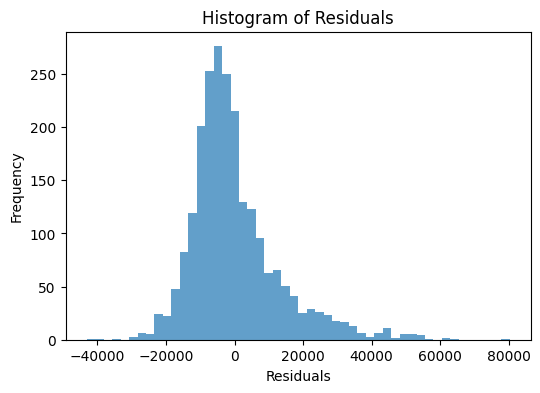

In [76]:
# Plot histogram of residuals
fig = plt.figure(figsize=(6, 4))
n, bins, patches = plt.hist(model.resid, bins=50, alpha=0.7)

# Set axes labels and plot title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

# Show the plot
plt.show()

a bit right skewed, man könnte es verbessern

## Random forest regression

### Fit Random forest regression model

In [77]:
# Initialize the random forest regressor
reg_rf = RandomForestRegressor(n_estimators=100, max_depth= 20,  random_state=42)


# Fit the model
reg_rf.fit(x_train, y_train)


# Calculate coefficient of determination (R-squared), round to 4 decimal places with f-string formatting
r2 = r2_score(y_test, reg_rf.predict(x_test))
print(f'R-squared: {r2:.4f}')

R-squared: 0.4764


jetzt gabs die verbesserung im vergleich zu oben

### Plot histogram of random forest regression residuals

In [78]:
# Calculate residuals


# Calculate residuals by subtracting actual target values from predicted values


# Plot histogram of residuals



### Show feature importance

In [79]:
# Get column names of X_train


# Derive feature importance from random forest


# Print col-names and importances-values


# Barplot with feature importance


### Jupyter notebook --footer info-- (please always provide this at the end of each submitted notebook)

In [80]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.5.0-1025-azure
Datetime: 2024-11-05 08:29:50
Python Version: 3.11.10
-----------------------------------
